<a href="https://colab.research.google.com/github/anhvt00/Memory-Consolidation-Modeling/blob/main/memory_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Experiments 1–3:** Single‑trace simulations exploring the effects of varying encoding strength ($c$), consolidation delay ($\tau$), and LTM decay rate ($\gamma$).

**Experiment 4:** Multi‑trace simulations without recurrent excitation, comparing conditions with/without competition and homogeneous vs. heterogeneous encoding.

**Experiment 5:** Multi‑trace simulations with recurrent excitation, showing the influence of decay and recurrent strength on memory retention (grouped bar plots).

**Experiment 6:** Timecourse simulations of multi‑trace dynamics under various conditions.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ============================
# Utility Functions
# ============================

def get_time_delay_single(T, dt, tau):
    """
    Computes the time vector and delay steps for single‐trace simulations.

    Parameters:
      T (float): Total simulation time.
      dt (float): Time step.
      tau (float): Delay time.

    Returns:
      t (np.ndarray): Time vector (length = steps+1).
      num_steps (int): Total number of simulation points.
      delay_steps (int): Number of steps corresponding to tau.
    """
    steps = int(T / dt)
    t = np.linspace(0, T, steps + 1)
    delay_steps = int(tau / dt)
    return t, steps + 1, delay_steps

def get_time_delay_multi(T, dt, tau):
    """
    Computes the time vector and delay steps for multi‐trace simulations.

    Parameters:
      T (float): Total simulation time.
      dt (float): Time step.
      tau (float): Delay time.

    Returns:
      t (np.ndarray): Time vector (length = n_steps).
      n_steps (int): Total number of simulation points.
      delay_steps (int): Number of steps corresponding to tau.
    """
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    delay_steps = int(tau / dt)
    return t, n_steps, delay_steps

def generate_square_pulse(num_steps, dt, pulse_duration=5.0):
    """
    Generates a square‐pulse input signal.

    Parameters:
      num_steps (int): Number of time steps in the simulation.
      dt (float): Time step size.
      pulse_duration (float): Duration for which the input is active.

    Returns:
      I (np.ndarray): Input array of shape (num_steps,).
    """
    pulse_steps = int(pulse_duration / dt)
    I = np.zeros(num_steps)
    I[:pulse_steps] = 1.0
    return I

def sigmoid(x):
    """
    Computes the sigmoid function.

    Parameters:
      x (float or np.ndarray): Input value(s).

    Returns:
      (float or np.ndarray): Sigmoid of the input.
    """
    return 1.0 / (1.0 + np.exp(-x))

# ============================
# Simulation Functions
# ============================

def simulate_single_trace(c=1.0, tau=5.0, alpha=0.5, beta=0.1, gamma=1e-5,
                          T=100, dt=0.01, input_duration=5.0):
    """
    Simulates a single‐trace memory model.

    Parameters:
      c, tau, alpha, beta, gamma, T, dt: Model parameters.
      input_duration (float): Duration for which the input is active.

    Returns:
      t (np.ndarray): Time vector.
      S (np.ndarray): Short‐term memory (STM) time course.
      L (np.ndarray): Long‐term memory (LTM) time course.
    """
    t, num_steps, delay_steps = get_time_delay_single(T, dt, tau)
    S = np.zeros(num_steps)
    L = np.zeros(num_steps)
    I = generate_square_pulse(num_steps, dt, pulse_duration=input_duration)

    for i in range(num_steps - 1):
        S_dot = c * I[i] - (alpha + beta) * S[i]
        S_tau = S[i - delay_steps] if i >= delay_steps else 0.0
        L_dot = beta * S_tau - gamma * L[i]
        S[i+1] = S[i] + dt * S_dot
        L[i+1] = L[i] + dt * L_dot

    return t, S, L

def simulate_multi_trace(c_i, lam, alpha=0.5, beta=0.1, gamma=1e-5,
                         kappa=0.5, tau=5.0, T=100, dt=0.01, rho=None):
    """
    Simulates multi‐trace memory dynamics.

    Parameters:
      c_i (np.ndarray): Encoding strengths for each trace.
      lam (float): LTM competition strength.
      rho: Recurrent excitation strength(s). If provided (scalar or array),
           recurrent excitation is applied; otherwise it is omitted.
      Other parameters: Model constants.

    Returns:
      t (np.ndarray): Time vector.
      S_all (np.ndarray): STM time courses (n_steps x N).
      L_all (np.ndarray): LTM time courses (n_steps x N).
    """
    t, n_steps, delay_steps = get_time_delay_multi(T, dt, tau)
    N = len(c_i)
    S_all = np.zeros((n_steps, N))
    L_all = np.zeros((n_steps, N))
    I = generate_square_pulse(n_steps, dt, pulse_duration=5.0)

    for t_idx in range(1, n_steps):
        I_val = I[t_idx]
        S_prev = S_all[t_idx - 1].copy()
        L_prev = L_all[t_idx - 1].copy()
        sum_S = S_prev.sum()
        sum_L = L_prev.sum()

        # Update STM vectorized
        S_all[t_idx] = S_prev + dt * (c_i * I_val - (alpha + beta) * S_prev -
                                     kappa * S_prev * (sum_S - S_prev))

        # Update LTM for each trace
        for j in range(N):
            S_delayed = S_all[t_idx - delay_steps, j] if t_idx >= delay_steps else 0.0
            competition = lam * L_prev[j] * (sum_L - L_prev[j])
            recurrent = 0.0
            if rho is not None:
                if hasattr(rho, '__iter__'):
                    recurrent = rho[j] * sigmoid(L_prev[j])
                else:
                    recurrent = rho * sigmoid(L_prev[j])
            dL = beta * S_delayed + recurrent - gamma * L_prev[j] - competition
            L_all[t_idx, j] = L_prev[j] + dt * dL

    return t, S_all, L_all

def simulate_multi_trace_timecourse(c_vals, rho_vals,
                                    alpha=0.5, beta=0.1, gamma=1e-5, tau=5.0,
                                    kappa=0.5, lam=0.5,
                                    dt=0.01, T=100.0):
    """
    Simulates the time evolution of a 3‐trace memory model.

    Parameters:
      c_vals (list): Encoding strengths for each trace.
      rho_vals (list): Recurrent excitation strengths for each trace.
      Other parameters: Model constants.

    Returns:
      time (np.ndarray): Time vector (steps,).
      S_all (np.ndarray): STM time courses (steps x N).
      L_all (np.ndarray): LTM time courses (steps x N).
    """
    N = len(c_vals)
    steps = int(np.round(T / dt))
    delay_steps = int(np.round(tau / dt))
    time = np.linspace(0, T, steps)
    S_all = np.zeros((steps, N))
    L_all = np.zeros((steps, N))

    for i in range(1, steps):
        t_val = i * dt
        I_val = 1.0 if t_val <= 5.0 else 0.0
        S_prev = S_all[i - 1].copy()
        L_prev = L_all[i - 1].copy()
        sum_S = S_prev.sum()
        sum_L = L_prev.sum()

        # Update STM
        for j in range(N):
            inhibition = kappa * S_prev[j] * (sum_S - S_prev[j])
            dS = (c_vals[j] * I_val) - (alpha + beta) * S_prev[j] - inhibition
            S_all[i, j] = S_prev[j] + dt * dS

        # Update LTM
        for j in range(N):
            S_delayed = S_all[i - delay_steps, j] if i >= delay_steps else 0.0
            sigma = sigmoid(L_prev[j])
            competition = lam * L_prev[j] * (sum_L - L_prev[j])
            dL = beta * S_delayed + rho_vals[j] * sigma - gamma * L_prev[j] - competition
            L_all[i, j] = L_prev[j] + dt * dL

    return time, S_all, L_all


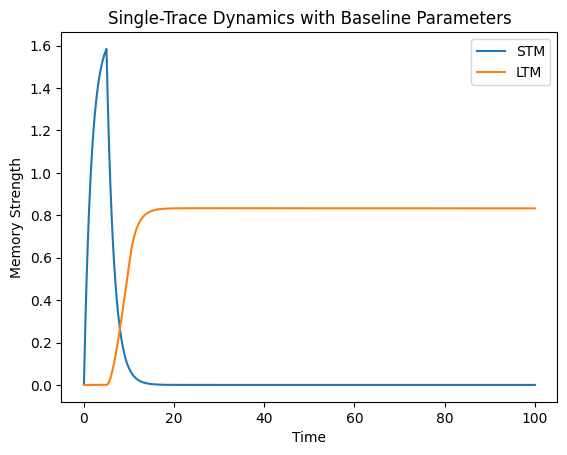

In [ ]:
# Single-trace simulation with baseline parameters
# Baseline parameters: c=1.0, tau=5.0, alpha=0.5, beta=0.1, gamma=1e-5, dt=0.01, T=100, input_duration=5.0

# Simulate the single trace
t, S, L = simulate_single_trace(
    c=1.0,
    tau=5.0,
    alpha=0.5,
    beta=0.1,
    gamma=1e-5,
    dt=0.01,
    T=100,
    input_duration=5.0
)

# Plot the STM and LTM dynamics
import matplotlib.pyplot as plt

plt.plot(t, S, label="STM")
plt.plot(t, L, label="LTM")
plt.xlabel("Time")
plt.ylabel("Memory Strength")
plt.title("Single-Trace Dynamics with Baseline Parameters")
plt.legend()
plt.show()


## Experiments 1–3: Single‐Trace Dynamics

The following experiments explore the effects of varying key parameters in the single‐trace model:

- **Experiment 1:** Effect of Encoding Strength ($c$)
- **Experiment 2:** Effect of Consolidation Delay ($\tau$)
- **Experiment 3:** Effect of LTM Decay Rate ($\gamma$)

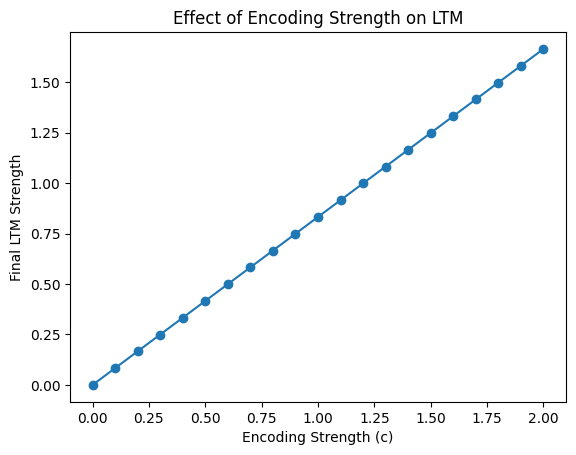

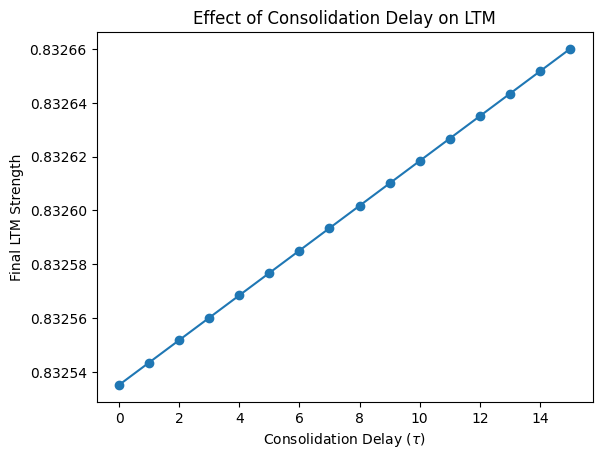

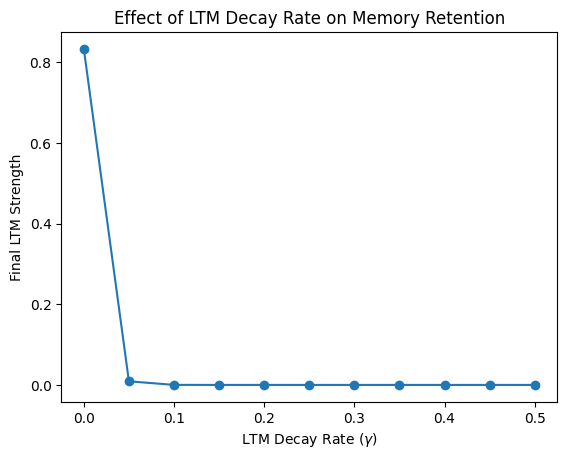

In [ ]:
# Experiment 1: Vary Encoding Strength (c)
c_values = np.arange(0, 2.1, 0.1)
results_c = []
for c_val in c_values:
    t, S, L = simulate_single_trace(c=c_val)
    peak_L, final_L, slope = compute_metrics(t, L)
    results_c.append([c_val, peak_L, final_L, slope])

df_c = pd.DataFrame(results_c, columns=["c", "peak_L", "final_L", "log_decay_slope"])

plt.figure()
plt.plot(df_c["c"], df_c["final_L"], 'o-')
plt.xlabel("Encoding Strength (c)")
plt.ylabel("Final LTM Strength")
plt.title("Effect of Encoding Strength on LTM")
plt.show()

# Experiment 2: Vary Consolidation Delay (τ)
tau_values = np.arange(0, 16, 1)
results_tau = []
for tau_val in tau_values:
    t, S, L = simulate_single_trace(tau=tau_val)
    peak_L, final_L, slope = compute_metrics(t, L)
    results_tau.append([tau_val, peak_L, final_L, slope])

df_tau = pd.DataFrame(results_tau, columns=["tau", "peak_L", "final_L", "log_decay_slope"])

plt.figure()
plt.plot(df_tau["tau"], df_tau["final_L"], 'o-')
plt.xlabel(r"Consolidation Delay ($\tau$)")
plt.ylabel("Final LTM Strength")
plt.title("Effect of Consolidation Delay on LTM")
plt.show()

# Experiment 3: Vary LTM Decay Rate (γ)
gamma_values = np.arange(0, 0.51, 0.05)
results_gamma = []
for gamma_val in gamma_values:
    t, S, L = simulate_single_trace(gamma=gamma_val)
    peak_L, final_L, slope = compute_metrics(t, L)
    results_gamma.append([gamma_val, peak_L, final_L, slope])

df_gamma = pd.DataFrame(results_gamma, columns=["gamma", "peak_L", "final_L", "log_decay_slope"])

plt.figure()
plt.plot(df_gamma["gamma"], df_gamma["final_L"], 'o-')
plt.xlabel(r"LTM Decay Rate ($\gamma$)")
plt.ylabel("Final LTM Strength")
plt.title("Effect of LTM Decay Rate on Memory Retention")
plt.show()

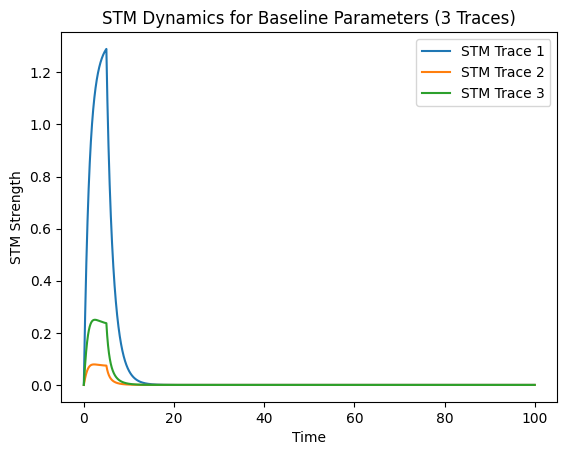

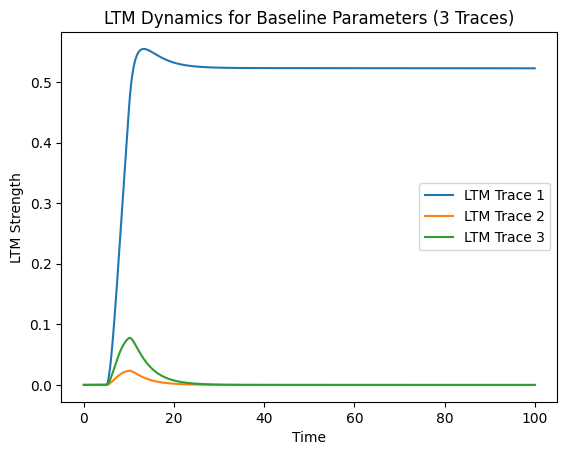

In [ ]:
# Baseline parameters for the three traces
baseline_params = {
    "c": [1.0, 0.1, 0.3],
    "rho": [0.0, 0.0, 0.0]  # No recurrent excitation for the baseline
}

# Fixed model parameters
alpha = 0.5
beta = 0.1
gamma = 1e-5
tau = 5.0
kappa = 0.5
lam = 0.5
dt = 0.01
T = 100.0

# Simulate the time evolution using the multi-trace timecourse function.
# (Assumes the function simulate_multi_trace_timecourse is defined in the notebook.)
t, S_all, L_all = simulate_multi_trace_timecourse(
    c_vals=baseline_params["c"],
    rho_vals=baseline_params["rho"],
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    tau=tau,
    kappa=kappa,
    lam=lam,
    dt=dt,
    T=T
)

# Plot STM (Short-Term Memory) for the three traces

for i in range(len(baseline_params["c"])):
    plt.plot(t, S_all[:, i], label=f"STM Trace {i+1}")
plt.xlabel("Time")
plt.ylabel("STM Strength")
plt.title("STM Dynamics for Baseline Parameters (3 Traces)")
plt.legend()
plt.show()

# Plot LTM (Long-Term Memory) for the three traces
for i in range(len(baseline_params["c"])):
    plt.plot(t, L_all[:, i], label=f"LTM Trace {i+1}")
plt.xlabel("Time")
plt.ylabel("LTM Strength")
plt.title("LTM Dynamics for Baseline Parameters (3 Traces)")
plt.legend()
plt.show()


## Experiment 4: Multi‐Trace Dynamics (No Recurrent Excitation)

In this experiment I simulate a multi‐trace model (without recurrent excitation) under four conditions:

- **No Competition, Homogeneous:** c = [1.0, 1.0, 1.0], $\lambda$ = 0.0
- **With Competition, Homogeneous:** c = [1.0, 1.0, 1.0], $\lambda$ = 0.5
- **No Competition, Heterogeneous:** c = [1.0, 0.5, 0.1], $\lambda$ = 0.0
- **With Competition, Heterogeneous:** c = [1.0, 0.5, 0.1], $\lambda$ = 0.5

For each condition I run 30 replicates, compute the mean and standard deviation of the final LTM strength for each trace, and then display the results as bar plots.

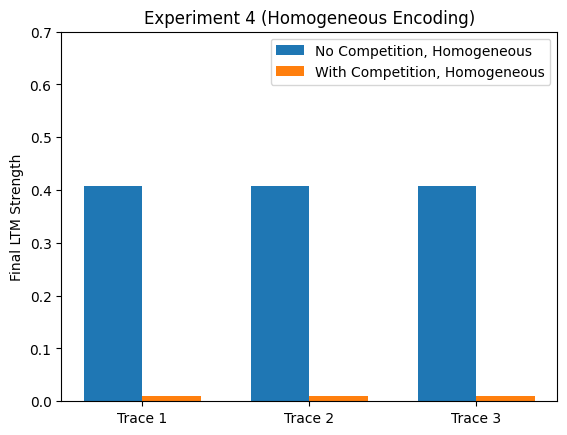

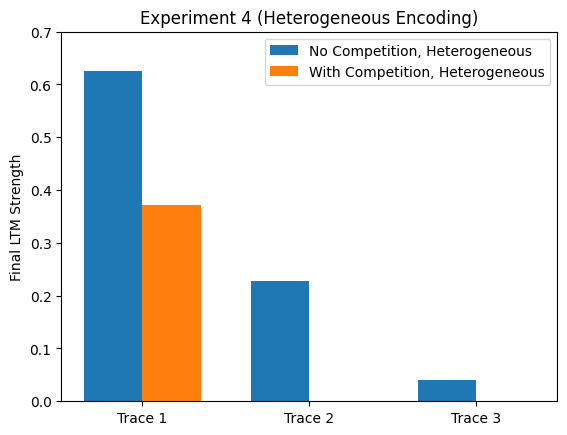

In [ ]:
# Define conditions for Experiment 4
conditions = [
    ("No Competition, Homogeneous", 0.0, np.array([1.0, 1.0, 1.0])),
    ("With Competition, Homogeneous", 0.5, np.array([1.0, 1.0, 1.0])),
    ("No Competition, Heterogeneous", 0.0, np.array([1.0, 0.5, 0.1])),
    ("With Competition, Heterogeneous", 0.5, np.array([1.0, 0.5, 0.1]))
]

records = []
for name, lam_val, c_i in conditions:
    finals = np.array([simulate_multi_trace(c_i, lam=lam_val, rho=None)[2][-1] for _ in range(30)])
    for i in range(3):
        records.append({
            'Condition': name,
            'Trace': f'Trace {i+1}',
            'Mean': finals[:, i].mean(),
            'STD': finals[:, i].std()
        })

df_exp4 = pd.DataFrame(records)

# Pivot and plot for homogeneous conditions
pivot_mean = df_exp4.pivot(index='Trace', columns='Condition', values='Mean')
pivot_std = df_exp4.pivot(index='Trace', columns='Condition', values='STD')

plt.figure()
conds_homo = ['No Competition, Homogeneous', 'With Competition, Homogeneous']
x = np.arange(len(pivot_mean))
width = 0.35
plt.bar(x - width/2, pivot_mean[conds_homo[0]], width, yerr=pivot_std[conds_homo[0]], label=conds_homo[0])
plt.bar(x + width/2, pivot_mean[conds_homo[1]], width, yerr=pivot_std[conds_homo[1]], label=conds_homo[1])
plt.xticks(x, pivot_mean.index)
plt.ylim(0, 0.7)
plt.ylabel('Final LTM Strength')
plt.title('Experiment 4 (Homogeneous Encoding)')
plt.legend()
plt.show()

# Plot for heterogeneous conditions
plt.figure()
conds_het = ['No Competition, Heterogeneous', 'With Competition, Heterogeneous']
plt.bar(x - width/2, pivot_mean[conds_het[0]], width, yerr=pivot_std[conds_het[0]], label=conds_het[0])
plt.bar(x + width/2, pivot_mean[conds_het[1]], width, yerr=pivot_std[conds_het[1]], label=conds_het[1])
plt.xticks(x, pivot_mean.index)
plt.ylim(0, 0.7)
plt.ylabel('Final LTM Strength')
plt.title('Experiment 4 (Heterogeneous Encoding)')
plt.legend()
plt.show()


## Experiment 5: Multi‐Trace Dynamics with Recurrent Excitation

In Experiment 5 I simulate a multi‐trace model with recurrent excitation. I vary the LTM decay rate ($\gamma$) and the recurrent excitation strength ($\rho$) and run 30 replicates for each combination. Finally, I display the mean and standard deviation for each trace using grouped bar plots.



=== EXPERIMENT 5 RESULTS TABLE ===
    Decay (γ)  Recurrent Strength (ρ)    Trace  Mean Final LTM  STD Final LTM
0     0.00001                     0.0  Trace 1    3.716950e-01   5.551115e-17
1     0.00001                     0.0  Trace 2    7.058653e-09   8.271806e-25
2     0.00001                     0.0  Trace 3    8.294177e-10   2.067952e-25
3     0.00001                     1.0  Trace 1    8.351218e-01   2.220446e-16
4     0.00001                     1.0  Trace 2    8.351218e-01   0.000000e+00
5     0.00001                     1.0  Trace 3    8.351218e-01   2.220446e-16
6     0.10000                     0.0  Trace 1    4.635615e-05   0.000000e+00
7     0.10000                     0.0  Trace 2    2.890009e-06   8.470329e-22
8     0.10000                     0.0  Trace 3    3.604832e-07   1.588187e-22
9     0.10000                     1.0  Trace 1    7.795014e-01   3.330669e-16
10    0.10000                     1.0  Trace 2    7.795014e-01   1.110223e-16
11    0.10000                

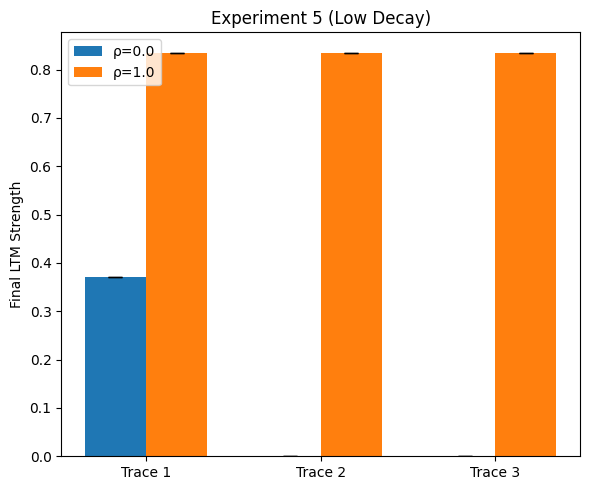

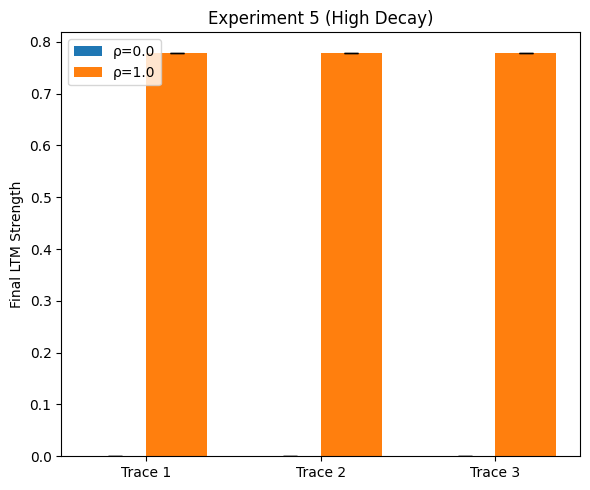

In [ ]:
def run_experiment5():
    gammas = [1e-5, 0.1]   # Low decay vs. high decay
    rhos = [0.0, 1.0]      # Recurrent strengths
    num_reps = 30          # Number of replicates
    records = []

    for gamma_val in gammas:
        for rho_val in rhos:
            finals_all = []
            for _ in range(num_reps):
                # Using simulate_multi_trace with recurrent excitation (rho provided)
                L_final = simulate_multi_trace(np.array([1.0, 0.5, 0.1]), lam=0.5, rho=rho_val,
                                               gamma=gamma_val, alpha=0.5, beta=0.1,
                                               kappa=0.5, tau=5.0, T=100, dt=0.01)[2][-1]
                finals_all.append(L_final)
            finals_all = np.array(finals_all)
            for i in range(3):
                records.append({
                    "Decay (γ)": gamma_val,
                    "Recurrent Strength (ρ)": rho_val,
                    "Trace": f"Trace {i+1}",
                    "Mean Final LTM": finals_all[:, i].mean(),
                    "STD Final LTM": finals_all[:, i].std()
                })
    return pd.DataFrame(records)

df_exp5 = run_experiment5()
print("=== EXPERIMENT 5 RESULTS TABLE ===")
print(df_exp5)

def plot_experiment5_bar_separate(df, gamma_val, title_suffix):
    """
    Plots a grouped bar chart for final LTM strength vs. recurrent strength
    for a given decay (γ) value.
    """
    df_gamma = df[df["Decay (γ)"] == gamma_val]
    pivot_mean = df_gamma.pivot(index="Trace", columns="Recurrent Strength (ρ)", values="Mean Final LTM")
    pivot_std  = df_gamma.pivot(index="Trace", columns="Recurrent Strength (ρ)", values="STD Final LTM")
    pivot_mean = pivot_mean[sorted(pivot_mean.columns)]
    pivot_std  = pivot_std[sorted(pivot_std.columns)]
    x = np.arange(len(pivot_mean))
    width = 0.35
    offsets = np.linspace(-width/2, width/2, len(pivot_mean.columns))

    fig, ax = plt.subplots(figsize=(6, 5))
    for i, rho_val in enumerate(pivot_mean.columns):
        ax.bar(x + offsets[i], pivot_mean[rho_val], width, yerr=pivot_std[rho_val], capsize=5, label=f"ρ={rho_val}")
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_mean.index)
    ax.set_ylabel("Final LTM Strength")
    ax.set_title(f"Experiment 5 ({title_suffix} Decay)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_experiment5_bar_separate(df_exp5, 1e-5, "Low")
plot_experiment5_bar_separate(df_exp5, 0.1, "High")


## Experiment 6: Timecourse Simulation for Multi‐Trace Dynamics

In Experiment 6 I simulate the full time courses (STM and LTM) for a multi‐trace model under several conditions. The conditions are defined with different encoding strengths and recurrent excitation values. Below, the helper function `simulate_multi_trace_timecourse` is used and the LTM time courses are plotted.

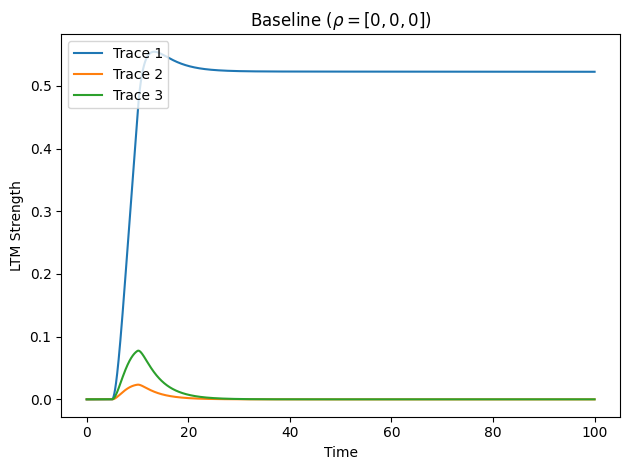

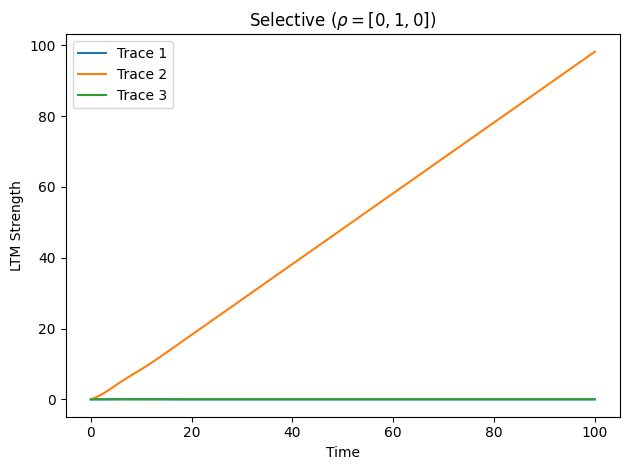

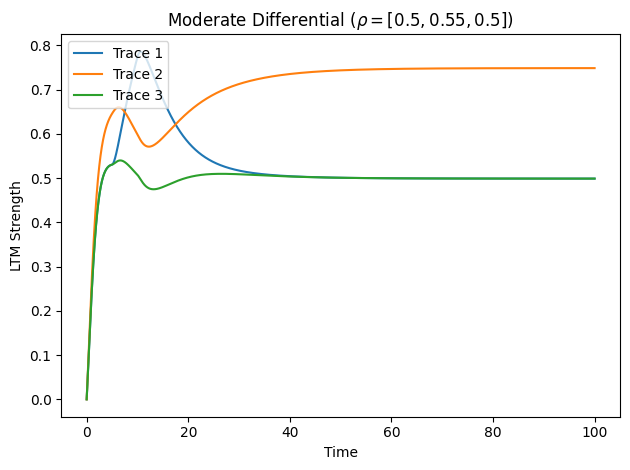

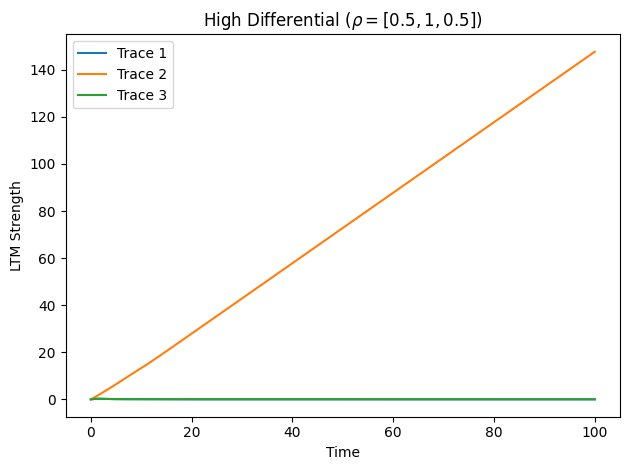

In [ ]:
# Define conditions for Experiment 6
conditions = {
    r"Baseline ($\rho=[0,0,0]$)": {
        "c": [1.0, 0.1, 0.3],
        "rho": [0.0, 0.0, 0.0]
    },
    r"Selective ($\rho=[0,1,0]$)": {
        "c": [1.0, 0.1, 0.3],
        "rho": [0.0, 1.0, 0.0]
    },
    r"Moderate Differential ($\rho=[0.5,0.55,0.5]$)": {
        "c": [1.0, 0.1, 0.3],
        "rho": [0.5, 0.55, 0.5]
    },
    r"High Differential ($\rho=[0.5,1,0.5]$)": {
        "c": [1.0, 0.1, 0.3],
        "rho": [0.5, 2.0, 0.5]
    }
}

# Fixed parameters
alpha = 0.5
beta = 0.1
gamma = 1e-5
tau = 5.0
kappa = 0.5
lam = 0.5
dt = 0.01
T = 100.0

for condition_title, params in conditions.items():
    t_vec, S_all, L_all = simulate_multi_trace_timecourse(
        c_vals = params["c"],
        rho_vals = params["rho"],
        alpha = alpha,
        beta = beta,
        gamma = gamma,
        tau = tau,
        kappa = kappa,
        lam = lam,
        dt = dt,
        T = T
    )

    plt.figure()
    for j in range(len(params["c"])):
        plt.plot(t_vec, L_all[:, j], label=f"Trace {j+1}")
    plt.title(condition_title)
    plt.xlabel("Time")
    plt.ylabel("LTM Strength")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
